In [1]:
from nlprocessing import ProcessCorpus
import pandas as pd
from nltk.corpus import words
import gensim

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
data1 = pd.read_csv('../data/comments.csv', sep='|').dropna()
data2 = pd.read_csv('../data/more_comments.csv').dropna()
data = data1.append(data2, ignore_index=True)
data = data[~data.duplicated()]
data = data[data['subreddit'] != 'politics']
test = data['text']#.sample(n=10000)

In [4]:
corpus = ProcessCorpus()
corpus.fit(test, frequency=10)

In [27]:
model = gensim.models.LdaModel(
    corpus=corpus.gensim_corpus_filtered,
    id2word=corpus.gensim_dictionary,
    num_topics=12,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    eta='auto',
    per_word_topics=True
)

In [15]:
coherence = gensim.models.CoherenceModel(
    model=model,
    texts=corpus.corpus,
    corpus=corpus.gensim_corpus
)
coherence.get_coherence()

0.5025058625378811

In [11]:
def find_perplexity_coherence(n_topics):
    model = gensim.models.LdaModel(
        corpus=corpus.gensim_corpus_filtered,
        id2word=corpus.gensim_dictionary,
        num_topics=n_topics,
        update_every=1,
        chunksize=100,
        passes=10,
        alpha='auto',
        eta='auto',
        per_word_topics=True
    )
    coherence = gensim.models.CoherenceModel(
        model=model,
        texts=corpus.corpus_filtered,
        corpus=corpus.gensim_corpus_filtered
    )
    return [n_topics, model.log_perplexity(corpus.gensim_corpus_filtered), coherence.get_coherence()]

In [17]:
def new_random_sample():
    test = data['text'].sample(n=10000)
    corpus = ProcessCorpus()
    corpus.fit(test, frequency=2)
    return corpus

In [12]:
def optimize_model(start=2, stop=10, step=1, n=1):
    coherence = {new_list: [] for new_list in range(start,stop,step)}
    perplexity = {new_list: [] for new_list in range(start,stop,step)}
    for j in range(n):
#         corpus = new_random_sample()
        for i in range(start, stop, step):
            _, p, c = find_perplexity_coherence(i)
            coherence[i].append(c)
            perplexity[i].append(p)
    return coherence, perplexity

In [13]:
def mean_dict(dictionary):
    mean = {}
    for key in dictionary:
        mean[key] = sum(dictionary[key])/len(dictionary[key])
    return mean

In [20]:
c, p = optimize_model(3,22,3)

/home/jules/anaconda3/lib/python3.7/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
/home/jules/anaconda3/lib/python3.7/site-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


In [21]:
c

{3: [0.2827508397224222],
 6: [0.4044920134511913],
 9: [0.4617614930674969],
 12: [0.46947574369227446],
 15: [nan],
 18: [nan],
 21: [nan]}

In [22]:
p

{3: [-8.753272295201654],
 6: [-9.228116229840008],
 9: [-9.74972656645882],
 12: [-10.566698790801073],
 15: [-13.779304024390425],
 18: [-20.72687302365367],
 21: [-26.56479091214496]}

In [23]:
import numpy as np
x = list(c.keys())
y_c = list(c.values())
y_p = list(p.values())

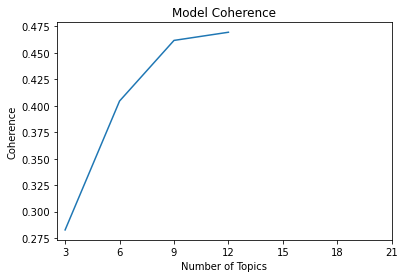

In [24]:
plt.plot(x, y_c)
plt.title('Model Coherence')
plt.xlabel('Number of Topics')
plt.xticks(range(3,22,3))
plt.ylabel('Coherence');
plt.savefig('../img/coherence_filtered.png')

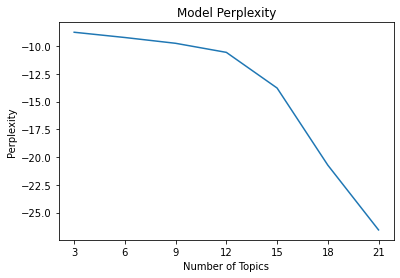

In [25]:
plt.plot(x, np.array(y_p))
plt.title('Model Perplexity')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.xticks(range(3,22,3));
plt.savefig('../img/perplexity_filtered.png')

In [ ]:
# model = gensim.models.LdaModel.load('mdl/model2/full_corpus_model')

In [12]:
model.get_document_topics(corpus.gensim_corpus, per_word_topics=True)[50]

([(0, 0.33138776),
  (1, 0.06677586),
  (2, 0.01016437),
  (3, 0.20406939),
  (5, 0.14906803),
  (6, 0.103684165),
  (7, 0.017829698),
  (8, 0.032781985),
  (9, 0.0835679)],
 [],
 [])

In [28]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus.gensim_corpus_filtered, corpus.gensim_dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.239950  0.346583       1        1  25.018984
5     -0.295416 -0.297072       2        1  19.890863
7     -0.112706  0.100228       3        1  15.893493
8     -0.084275 -0.055352       4        1  10.813312
9      0.008902 -0.027755       5        1   6.323972
4      0.060149 -0.016253       6        1   4.261904
2     -0.048398 -0.044785       7        1   4.193958
1      0.139136 -0.003012       8        1   3.861127
0      0.058255 -0.016285       9        1   3.772363
3      0.158703  0.000038      10        1   3.416112
11     0.173607  0.004010      11        1   1.297462
6      0.181993  0.009654      12        1   1.256450, topic_info=                 Term          Freq         Total Category  logprob  loglift
553              hodl  20547.000000  20547.000000  Default  30.0000  30.0000
2511          bitcoin   9795.000000   9795.000000  Default  29.0000  29.0000
49             buying  19477.000000  19477.000000  Default  28.0000  28.0000
3405          hodling  21645.000000  21645.000000  Default  27.0000  27.0000
592               lol   9357.000000   9357.000000  Default  26.0000  26.0000
...               ...           ...           ...      ...      ...      ...
8591              cdc      0.213962      1.966718  Topic12 -10.2388   2.1586
13880  permissionless      0.213188      1.972010  Topic12 -10.2425   2.1522
8723           hosted      0.215382      1.995215  Topic12 -10.2322   2.1508
13886            asic      0.222474      2.075711  Topic12 -10.1998   2.1436
12840         adjusts      0.214242      1.990319  Topic12 -10.2375   2.1479

[407 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2957      4  0.999093  accepting
3495      1  0.995669    accepts
1423      3  0.998249     adding
1532      6  0.984488    allowed
5693      6  0.993891     allows
...     ...       ...        ...
6951      3  0.997575         🤣🤣
4936      1  0.105769        🤣🤣🤣
4936      2  0.746102        🤣🤣🤣
4936      3  0.145790        🤣🤣🤣
4573      9  0.871859          🤷

[350 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 6, 8, 9, 10, 5, 3, 2, 1, 4, 12, 7])

In [29]:
pyLDAvis.save_html(vis,'../img/lda_vis3.html')

In [30]:
model.save('mdl/model3/optimized')